In [77]:
!pip install torch_geometric

In [78]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv, GCNConv, GATConv
import torch.nn.functional as F

In [79]:
# Load dataset
df = pd.read_csv('/content/synesthesia_dataset.csv')
print(df.head())  # Display first few rows

     Color       Genre     Emotion
0  Magenta       Lo-fi   Dreamlike
1  Magenta       Lo-fi  Melancholy
2   Maroon         Pop     Hopeful
3   Orange  Electronic     Chaotic
4     Navy       Blues  Loneliness


In [80]:
print(df.columns)
df.columns = df.columns.str.lower()  # Converts all column names to lowercase
print(df.columns)

Index(['Color', 'Genre', 'Emotion'], dtype='object')
Index(['color', 'genre', 'emotion'], dtype='object')


In [81]:
# Encode colors as RGB values (assuming standard color names)
import matplotlib.colors as mcolors
color_to_rgb = {color: mcolors.to_rgb(color) for color in df['color'].unique()}
df['color_rgb'] = df['color'].map(color_to_rgb)

# One-hot encode genres
genre_encoder = OneHotEncoder(sparse_output=False)
genre_encoded = genre_encoder.fit_transform(df[['genre']])
df['genre_encoded'] = list(genre_encoded)

# Encode emotions as numerical labels
emotion_encoder = LabelEncoder()
df['emotion_encoded'] = emotion_encoder.fit_transform(df['emotion'])

In [82]:
# Create a bipartite graph
G = nx.Graph()

# Add nodes
colors = df['color'].unique()
genres = df['genre'].unique()
G.add_nodes_from(colors, bipartite=0)  # Color nodes
G.add_nodes_from(genres, bipartite=1)  # Genre nodes

# Add edges with emotion as attributes
edges = [(row['color'], row['genre'], {'emotion': row['emotion_encoded']}) for _, row in df.iterrows()]
G.add_edges_from(edges)

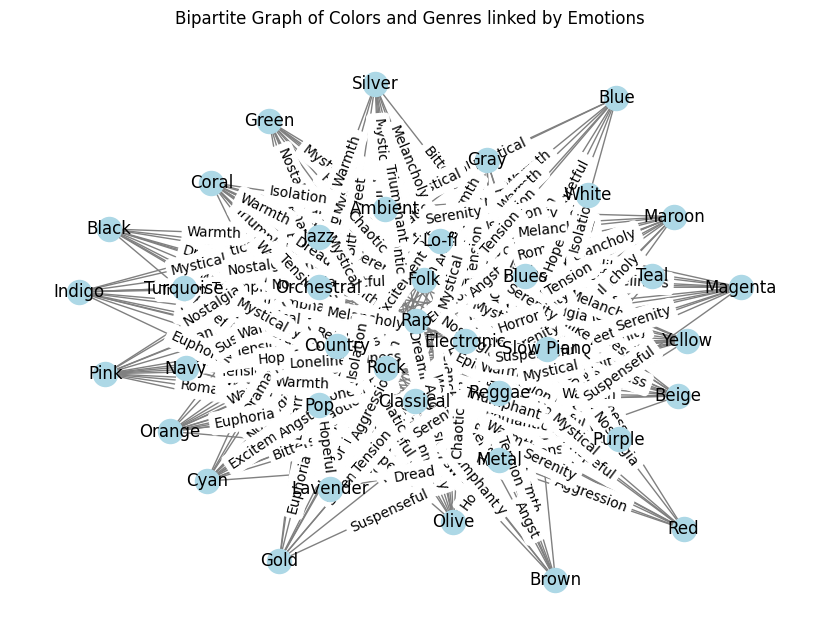

In [83]:
# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(row['color'], row['genre']): row['emotion'] for _, row in df.iterrows()})
plt.title("Bipartite Graph of Colors and Genres linked by Emotions")
plt.show()

In [84]:
# Convert to PyTorch Geometric format
data = from_networkx(G)
color_features = torch.tensor(list(df['color_rgb']), dtype=torch.float)
genre_features = torch.tensor(np.array(df['genre_encoded'].tolist()), dtype=torch.float)
data.x = torch.cat((color_features, genre_features), dim=1)
data.edge_attr = torch.tensor([edge[2]['emotion'] for edge in edges], dtype=torch.long)

# Train/test split
num_edges = data.edge_index.shape[1]
num_train = int(0.8 * num_edges)
perm = torch.randperm(num_edges)
train_edges = perm[:num_train]
test_edges = perm[num_train:]
data.train_edge_index = data.edge_index[:, train_edges]
data.test_edge_index = data.edge_index[:, test_edges]
data.train_edge_attr = data.edge_attr[train_edges]
data.test_edge_attr = data.edge_attr[test_edges]

In [85]:
# Define GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type="GraphSAGE"):
        super(GNNModel, self).__init__()
        if model_type == "GraphSAGE":
            self.conv1 = SAGEConv(in_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, out_channels)
        elif model_type == "GCN":
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
        elif model_type == "GAT":
            self.conv1 = GATConv(in_channels, hidden_channels)
            self.conv2 = GATConv(hidden_channels, out_channels)
        else:
            raise ValueError("Invalid model type. Choose from 'GraphSAGE', 'GCN', or 'GAT'")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [86]:
num_classes = df['emotion_encoded'].nunique()  # Count unique emotions

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = data.x.shape[1]
hidden_channels = 16
out_channels = num_classes
model = GNNModel(in_channels, hidden_channels, out_channels, model_type="GraphSAGE").to(device)

# Print Model Architecture
print(model)

GNNModel(
  (conv1): SAGEConv(18, 16, aggr=mean)
  (conv2): SAGEConv(16, 31, aggr=mean)
)


In [87]:
# Define Loss Function and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_edge_index[0]], data.train_edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[data.test_edge_index[0]].argmax(dim=1)
        correct = (pred == data.test_edge_attr).sum()
        acc = correct / data.test_edge_attr.size(0)
    return acc.item()

In [88]:
# Run Training
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train()
    acc = test()
    print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

Epoch 01, Loss: 3.4353, Test Accuracy: 0.0312
Epoch 02, Loss: 3.4090, Test Accuracy: 0.0391
Epoch 03, Loss: 3.3876, Test Accuracy: 0.0547
Epoch 04, Loss: 3.3674, Test Accuracy: 0.0547
Epoch 05, Loss: 3.3461, Test Accuracy: 0.0625
Epoch 06, Loss: 3.3235, Test Accuracy: 0.0703
Epoch 07, Loss: 3.3000, Test Accuracy: 0.0703
Epoch 08, Loss: 3.2769, Test Accuracy: 0.0625
Epoch 09, Loss: 3.2566, Test Accuracy: 0.0703
Epoch 10, Loss: 3.2409, Test Accuracy: 0.1016
Epoch 11, Loss: 3.2313, Test Accuracy: 0.1016
Epoch 12, Loss: 3.2270, Test Accuracy: 0.1016
Epoch 13, Loss: 3.2249, Test Accuracy: 0.1016
Epoch 14, Loss: 3.2217, Test Accuracy: 0.1016
Epoch 15, Loss: 3.2163, Test Accuracy: 0.1016
Epoch 16, Loss: 3.2091, Test Accuracy: 0.0859
Epoch 17, Loss: 3.2012, Test Accuracy: 0.0781
Epoch 18, Loss: 3.1935, Test Accuracy: 0.0781
Epoch 19, Loss: 3.1865, Test Accuracy: 0.0859
Epoch 20, Loss: 3.1804, Test Accuracy: 0.0859
Epoch 21, Loss: 3.1750, Test Accuracy: 0.0781
Epoch 22, Loss: 3.1698, Test Accur

In [90]:
print("Available colors:", list(color_to_rgb.keys()))

Available colors: ['Magenta', 'Maroon', 'Orange', 'Navy', 'White', 'Teal', 'Turquoise', 'Coral', 'Black', 'Olive', 'Blue', 'Cyan', 'Gray', 'Purple', 'Green', 'Indigo', 'Yellow', 'Silver', 'Brown', 'Red', 'Beige', 'Gold', 'Pink', 'Lavender']


In [91]:
print("Available genres:", list(df['genre'].unique()))

Available genres: ['Lo-fi', 'Pop', 'Electronic', 'Blues', 'Ambient', 'Folk', 'Rap', 'Orchestral', 'Metal', 'Classical', 'Slow Piano', 'Rock', 'Country', 'Jazz', 'Reggae']


In [98]:
def predict_emotion(color, genre):
    model.eval()

    # Convert color to RGB
    if color not in color_to_rgb:
        print("Invalid color")
        return
    color_rgb = torch.tensor(color_to_rgb[color], dtype=torch.float).to(device)

    # Convert genre to one-hot encoding (fix warning)
    try:
        genre_onehot = torch.tensor(genre_encoder.transform(np.array([[genre]])), dtype=torch.float).to(device)
        genre_onehot = genre_onehot.squeeze(0)  # Fix dimension mismatch (1D tensor)
    except ValueError:
        print("Invalid genre")
        return

    # Concatenate color and genre features
    input_features = torch.cat([color_rgb, genre_onehot], dim=0).unsqueeze(0)  # Shape: [1, feature_dim]

    # Create a dummy edge index to satisfy model expectations
    dummy_edge_index = torch.tensor([[0], [0]], dtype=torch.long).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(input_features, dummy_edge_index)
        predicted_emotion_idx = output.argmax(dim=1).item()

    # Ensure index is within bounds
    if predicted_emotion_idx >= len(emotion_encoder.classes_):
        print("Invalid prediction index")
        return

    # Decode emotion
    predicted_emotion = emotion_encoder.inverse_transform([predicted_emotion_idx])[0]
    print(f"Predicted Emotion for ({color}, {genre}): {predicted_emotion}")

In [99]:
predict_emotion("Red","Pop")

Predicted Emotion for (Red, Pop): Aggression


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
